# Conclusions

## Model with gender included in the features

* In analysed test data 2697 (67%) of all credit card applications come from females.
* The model rejected almost the same number of males and females, i.e. 112 and 123 applications. It means that 4.6% of females did not receive the credit card and around 8.6% of males were not granted the credit. 
* The model has 0.95 accuracy for females, and 0.90 accuracy for males. The difference is not huge, but significant.
* The recall for females euqals 0.15, while for males only 0.06.


## Model without gender

* This time share of males and females, who were rejected is closer than in the previous case, i.e. 5.5% of females and 7.6% of males. 
* Both model accuracy and recall are only a bit closer now, i.e. 
    - females: 0.944 accuracy , 0.128 recall
    - males: 0.919 accuracy , 0.071 recall

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
os.chdir("..")

In [3]:
from src.models.udfs_modelling import get_stats_by_gender

# Four key fairness criteria:
## **1. Demographic parity / statistical parity**

Demographic parity says the model is fair if the composition of people who are selected by the model matches the group membership percentages of the applicants.

## **2. Equal opportunity**

Equal opportunity fairness ensures that the proportion of people who should be selected by the model ("positives") that are correctly selected by the model is the same for each group. We refer to this proportion as the true positive rate (TPR) or sensitivity of the model.

## **3. Equal accuracy**

Alternatively, we could check that the model has equal accuracy for each group. That is, the percentage of correct classifications (people who should be denied and are denied, and people who should be approved who are approved) should be the same for each group. If the model is 98% accurate for individuals in one group, it should be 98% accurate for other groups.

In [4]:
infile = open('data/interim/model_training_rf','rb')
rf_dict = pickle.load(infile)
infile.close()

1. Demographic parity / statistical parity

Total observations: 4000
Group 0: 2697 (67.42%)
Group 1: 1303 (32.57%)

Total approvals: 235
Group 0: 123 (52.34% of all approvals) (4.56% of female approvals)
Group 1: 112 (47.66% of approvals) (8.6% of female approvals)

2. Equal opportunity

Sensitivity / Recall:
Group 0: 14.63%
Group 1: 6.25%

3. Equal accuracy

Overall accuracy: 93.82%
Group 0: 95.25%
Group 1: 90.87%


C:\Users\Winter\data_science\repos\credit-admission-prediction-python\src\models\udfs_modelling.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


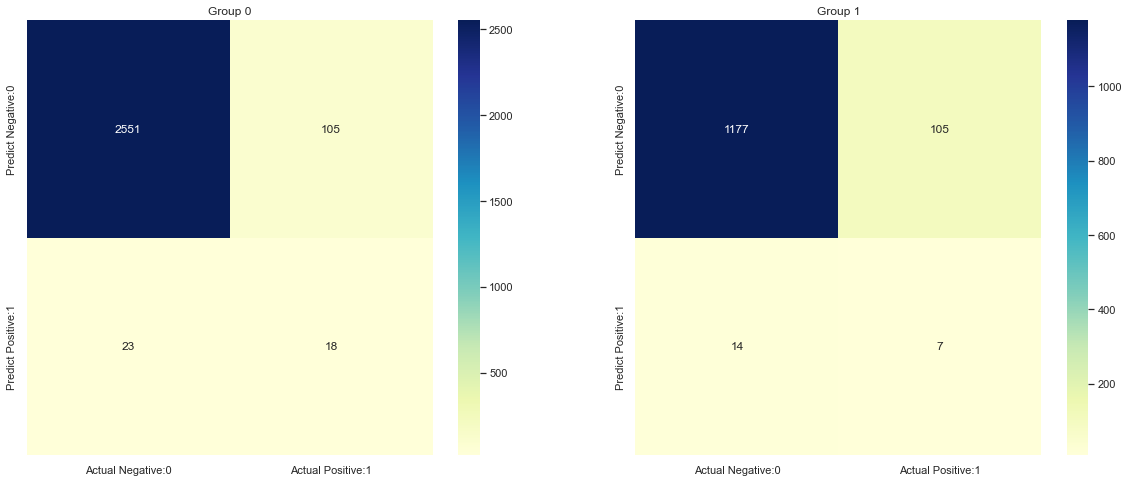

In [5]:
get_stats_by_gender(rf_dict['X_test_data'],
                    rf_dict['y_test_data'],
                    rf_dict['classifier'],
                    rf_dict['X_test_data']["code_gender"]==1)

## **4.Group unaware / "Fairness through unawareness"**

Group unaware fairness removes all group membership information from the dataset. For instance, we can remove gender data to try to make the model fair to different gender groups. Similarly, we can remove information about race or age.

### Fitting model with no code_gender in the feature set

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf_no_gender = RandomForestClassifier(**rf_dict['classifier'].get_params())
rf_no_gender = rf_no_gender.fit(rf_dict['X_train_data'].drop('code_gender', axis = 1),
                                rf_dict['y_train_data'])

1. Demographic parity / statistical parity

Total observations: 4000
Group 0: 2697 (67.42%)
Group 1: 1303 (32.57%)

Total approvals: 248
Group 0: 149 (60.08% of all approvals) (5.52% of female approvals)
Group 1: 99 (39.92% of approvals) (7.6% of female approvals)

2. Equal opportunity

Sensitivity / Recall:
Group 0: 12.75%
Group 1: 7.07%

3. Equal accuracy

Overall accuracy: 93.55%
Group 0: 94.36%
Group 1: 91.86%


C:\Users\Winter\data_science\repos\credit-admission-prediction-python\src\models\udfs_modelling.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


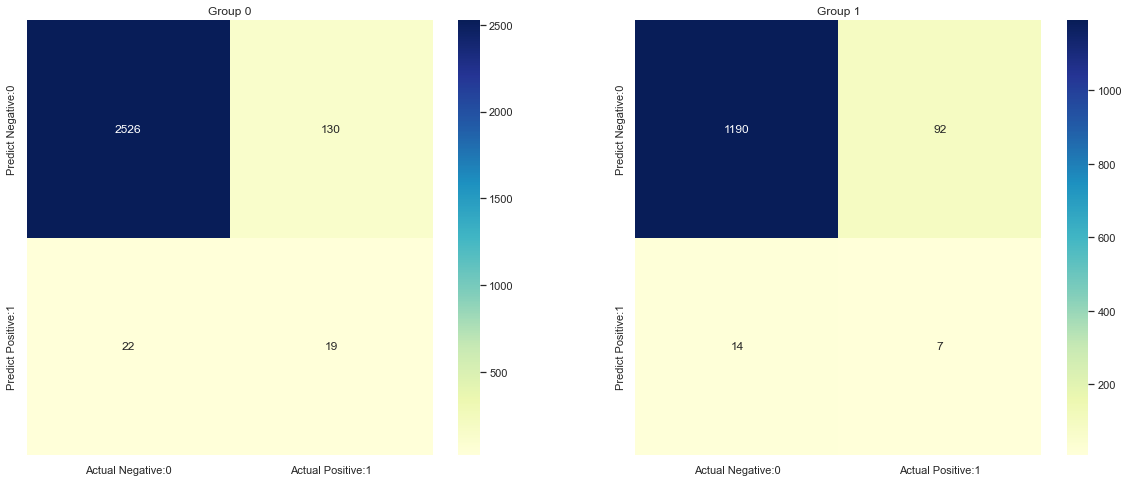

In [7]:
get_stats_by_gender(rf_dict['X_test_data'],
          rf_dict['y_test_data'],
          rf_no_gender,
          rf_dict['X_test_data']["code_gender"]==1,
          with_gender = False)